# Background.
This Project is to apply fine tuning towards exsistance model for better performance on specific datasets claasificaiton.

## Overal Structure.
The main training process can be split into three parts:
1. Dataset Process
2. Model Selection and structure re-shape
3. Training Configuration

Main Layout Look as below:
***IMG###################-----------------------------------########

**QuickLink**:
- *[Lib Import](##1.-Lib-Import)
- *[DataSet Process](#2.-DataSet-Process)
- *[Model Configuration](#3.-Model-Configuration)
- *[Training setting](#4.-Model-Configuration )

## 1. Lib Import

In [3]:
# Donwload the lib if not yet
!pip install -r requirements.txt

ERROR: Could not open requirements file: [Errno 2] No such file or directory: 'requirements.txt'


In [4]:
# Or Download Each lib by individual
!pip install torch
!pip install torchvision
!pip install torchinfo
!pip install numpy
!pip install matplotlib
!pip install pandas
!pip install Pillow
!pip install requests
!pip install kagglehub
!pip install shutil

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 111.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 83.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 49.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 861.5 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 82.7 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjit

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
import time
import numpy as np
import matplotlib.pyplot as plt
import os
import zipfile
import requests
from torchvision import datasets, models, transforms
from torchinfo import summary
from torch.utils.data import DataLoader
import random
import kagglehub
import shutil


In [6]:
##---------------------------------Device Config-----------------------------------##
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# 2. DataSet Process

##  Download DataSet from kaggle

In [12]:
##-----------------Download the Datasets from Kaggle------------------------------##

path = kagglehub.dataset_download("gpiosenka/cards-image-datasetclassification")

## Move the default data path from kaggle into the content folder

new_path = "/content/dataset"
shutil.move(path, new_path)
print("Dataset moved to:", new_path)
print(os.listdir(new_path))

##--------------------Mean and STD Value------------------------------------------##

## These two values need to be calculated, I provide the function in the next block
## For clarity, assume this value is already received. If not, calculate that before coming to this step
mean = [0.776,0.7291,0.7016]
std = [0.3079,0.3377,0.3443]


100%|██████████| 385M/385M [00:18<00:00, 22.2MB/s]

Extracting files...


Dataset moved to: /content/dataset
['valid', 'cards.csv', '2', '53cards-53-(200 X 200)-100.00.h5', 'train', '14card types-14-(200 X 200)-94.61.h5', 'test']


In [ ]:
## If Want the mean and std, then the number can be done by this
# def get_mean_std(loader):
#     mean = 0.
#     sq_mean = 0.
#     total_images = 0

#     for images, _ in loader:
#         batch_size = images.size(0)
#         images = images.view(batch_size, images.size(1), -1)
#         mean += images.mean(2).sum(0)
#         sq_mean += (images ** 2).mean(2).sum(0)
#         total_images += batch_size

#     mean /= total_images
#     std = (sq_mean / total_images - mean ** 2) ** 0.5

#     print(f"mean: {mean}, std: {std}")
#     return mean, std

# train_dataset = datasets.ImageFolder(root=train_root, transform=preprocess)
# train_loader = DataLoader(train_dataset, shuffle=True, batch_size=training_config.batch_size, num_workers=train_config.num_workers)
# mean, std = get_mean_std(train_loader)

## Data Preprocess

In [13]:
##------------------------------Define Image Transformer-------------------------------------------------##

image_transformer ={
    'train': transforms.Compose([
        transforms.RandomResizedCrop(size = 256, scale=(0.8,1.0)),
        transforms.RandomRotation(degrees=15),
        transforms.RandomHorizontalFlip(),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),        ##Convert data set to tensor format
        transforms.Normalize(mean =mean,  # Normalize image using mean
                             std = std)  # Normalize image using std deviation

    ]),
    'valid':transforms.Compose([
        transforms.Resize(size=256),
        transforms.ToTensor(),
        transforms.Normalize(mean =mean,
                             std = std)

    ]),
    'test':transforms.Compose([
        transforms.Resize(size=256),
        transforms.ToTensor(),
        transforms.Normalize(mean =mean,
                             std = std)
    ]),
}


## Data Loader

In [14]:
##---------------------------Load the Data------------------------------------------##
dataset = "dataset";
train_directory = os.path.join(dataset, "train")
valid_dirrectory = os.path.join(dataset, "valid")
test_dirrectory = os.path.join(dataset, "test")

# Batch Size
batch_size = 32;

#number of classes
num_classes = len(os.listdir(train_directory))
print(num_classes);

data = {
    'train': datasets.ImageFolder(root=train_directory, transform=image_transformer['train']),
    'valid': datasets.ImageFolder(root=valid_dirrectory, transform=image_transformer['valid']),
    'test': datasets.ImageFolder(root=test_dirrectory, transform=image_transformer['test'])
}

##Size of the train, val and data. For getting the average loss and accuracy
train_data_size = len(data['train']);
valid_data_size = len(data['valid']);
test_data_size = len(data['test']);

# Get a mapping of the indices to the class names, in order to see the output classes of the test image
idx_to_class = {v: k for k, v in data['train'].class_to_idx.items()}
print(idx_to_class)

##----------------------------------Data Loader-------------------------------------##
train_data_loader = DataLoader(data['train'], batch_size=batch_size, shuffle=True);
valid_data_loader = DataLoader(data['valid'], batch_size=batch_size, shuffle=False);
test_data_loader = DataLoader(data['test'], batch_size=batch_size, shuffle=False);


print(f"Number of training samples:   {train_data_size}")
print(f"Number of validation samples: {valid_data_size}"),
print(f"Number of test samples:       {test_data_size}")


53
{0: 'ace of clubs', 1: 'ace of diamonds', 2: 'ace of hearts', 3: 'ace of spades', 4: 'eight of clubs', 5: 'eight of diamonds', 6: 'eight of hearts', 7: 'eight of spades', 8: 'five of clubs', 9: 'five of diamonds', 10: 'five of hearts', 11: 'five of spades', 12: 'four of clubs', 13: 'four of diamonds', 14: 'four of hearts', 15: 'four of spades', 16: 'jack of clubs', 17: 'jack of diamonds', 18: 'jack of hearts', 19: 'jack of spades', 20: 'joker', 21: 'king of clubs', 22: 'king of diamonds', 23: 'king of hearts', 24: 'king of spades', 25: 'nine of clubs', 26: 'nine of diamonds', 27: 'nine of hearts', 28: 'nine of spades', 29: 'queen of clubs', 30: 'queen of diamonds', 31: 'queen of hearts', 32: 'queen of spades', 33: 'seven of clubs', 34: 'seven of diamonds', 35: 'seven of hearts', 36: 'seven of spades', 37: 'six of clubs', 38: 'six of diamonds', 39: 'six of hearts', 40: 'six of spades', 41: 'ten of clubs', 42: 'ten of diamonds', 43: 'ten of hearts', 44: 'ten of spades', 45: 'three of 

# 3. Model Configuration

## Model Selection & Transfer Several Layours

In [15]:
## Load Model
resnet50 = models.resnet50(weights='DEFAULT')
resnet50 = resnet50.to(device);

## Set all layers freeze initially
for param in resnet50.parameters():
    param.requires_grad = False

## Defreeze a few

for param in resnet50.layer4.parameters():
    param.requires_grad = True

for param in resnet50.layer3.parameters():
    param.requires_grad = True


fc_inputs = resnet50.fc.in_features
# Define a new ReLu for card classification
resnet50.fc = nn.Sequential(
    nn.Linear(fc_inputs, 256),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(256, num_classes),
    nn.LogSoftmax(dim=1)
)

# (either CUDA or CPU)
resnet50 = resnet50.to(device);

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 170MB/s]


## Training Config

In [16]:
##-------------------------Training Configuration-------------------------------------------------------##
loss_func = nn.NLLLoss();

##learning Rate
learning_rate = 0.01;

##using Stochastic Gradient Descent (SGD)
optimizer = optim.SGD(
    params=resnet50.parameters(),  # Optimizing all parameters of the ResNet50 model
    lr=learning_rate,  # Learning rate
    momentum=0.9  # avoid local minima
)

# 4. Training Setting

## Train and Validation Config

In [17]:
def train_and_validate(model, loss_criterion, optimizer, epochs=5):
    start = time.time()
    history = []
    best_loss = 100000.0
    best_epoch = None

    for epoch in range(epochs):
        epoch_start = time.time()
        print("Epoch: {}/{}".format(epoch+1, epochs))

        # Set to training mode
        model.train()

        # Loss and Accuracy within the epoch
        train_loss = 0.0
        train_acc = 0.0

        valid_loss = 0.0
        valid_acc = 0.0

        for i, (inputs, labels) in enumerate(train_data_loader):

            inputs = inputs.to(device)
            labels = labels.to(device)

            # Clean existing gradients
            optimizer.zero_grad()


            outputs = model(inputs)


            loss = loss_criterion(outputs, labels)

            # Backpropagate the gradients
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * inputs.size(0)

            # Compute the accuracy
            ret, predictions = torch.max(outputs.data, 1)
            correct_counts = predictions.eq(labels.data.view_as(predictions))

            # Convert correct_counts to float and then compute the mean
            acc = torch.mean(correct_counts.type(torch.FloatTensor))

            # Compute total accuracy in the whole batch and add to train_acc
            train_acc += acc.item() * inputs.size(0)

            # print("Batch number: {:03d}, Training Loss: {:.4f}, Accuracy: {:.4f}".format(i, loss.item(), acc.item()))
            # uncomment above for checking each batch performance

        # Validation
        with torch.no_grad():

            model.eval()
            for j, (inputs, labels) in enumerate(valid_data_loader):
                inputs = inputs.to(device)
                labels = labels.to(device)
                outputs = model(inputs)


                loss = loss_criterion(outputs, labels)
                valid_loss += loss.item() * inputs.size(0)

                ret, predictions = torch.max(outputs.data, 1)
                correct_counts = predictions.eq(labels.data.view_as(predictions))


                acc = torch.mean(correct_counts.type(torch.FloatTensor))
                valid_acc += acc.item() * inputs.size(0)

                #print("Validation Batch number: {:03d}, Validation: Loss: {:.4f}, Accuracy: {:.4f}".format(j, loss.item(), acc.item()))
                # The same you can uncomment this

        if valid_loss < best_loss:
            best_loss = valid_loss
            best_epoch = epoch
            # Save if the model has best accuracy for val
            torch.save(model, 'best_model.pt')

        avg_train_loss = train_loss/train_data_size
        avg_train_acc = train_acc/train_data_size
        avg_valid_loss = valid_loss/valid_data_size
        avg_valid_acc = valid_acc/valid_data_size

        history.append([avg_train_loss, avg_valid_loss, avg_train_acc, avg_valid_acc])

        epoch_end = time.time()

        print("Epoch : {:03d}, Training: Loss - {:.4f}, Accuracy - {:.4f}%, \n\t\tValidation : Loss - {:.4f}, Accuracy - {:.4f}%, Time: {:.4f}s".format(epoch, avg_train_loss, avg_train_acc*100, avg_valid_loss, avg_valid_acc*100, epoch_end-epoch_start))




    return model, history, best_epoch

## Actual Training

In [22]:
print(summary(resnet50, input_size=(batch_size, 3, 224, 224))) ## See How many Parameters there are now, crazy

##-------------------------Train Begin--------------------------------------------------##
num_epochs = 25
trained_model, history, best_epoch = train_and_validate(resnet50, loss_func, optimizer, num_epochs)

torch.save(history, dataset+'_history.pt')

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [32, 53]                  --
├─Conv2d: 1-1                            [32, 64, 112, 112]        (9,408)
├─BatchNorm2d: 1-2                       [32, 64, 112, 112]        (128)
├─ReLU: 1-3                              [32, 64, 112, 112]        --
├─MaxPool2d: 1-4                         [32, 64, 56, 56]          --
├─Sequential: 1-5                        [32, 256, 56, 56]         --
│    └─Bottleneck: 2-1                   [32, 256, 56, 56]         --
│    │    └─Conv2d: 3-1                  [32, 64, 56, 56]          (4,096)
│    │    └─BatchNorm2d: 3-2             [32, 64, 56, 56]          (128)
│    │    └─ReLU: 3-3                    [32, 64, 56, 56]          --
│    │    └─Conv2d: 3-4                  [32, 64, 56, 56]          (36,864)
│    │    └─BatchNorm2d: 3-5             [32, 64, 56, 56]          (128)
│    │    └─ReLU: 3-6                    [32, 64, 56, 56]   

# Evaluation

## Accuracy and Loss Trend

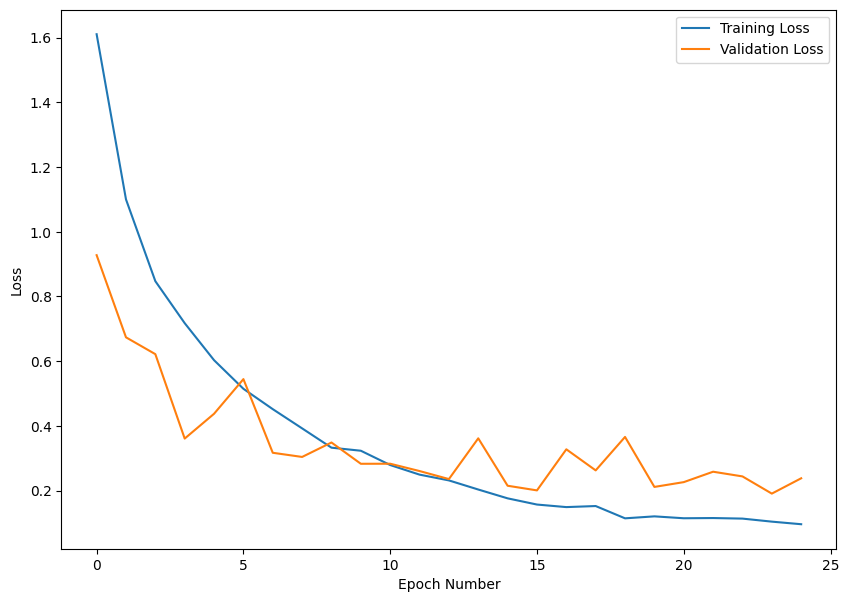

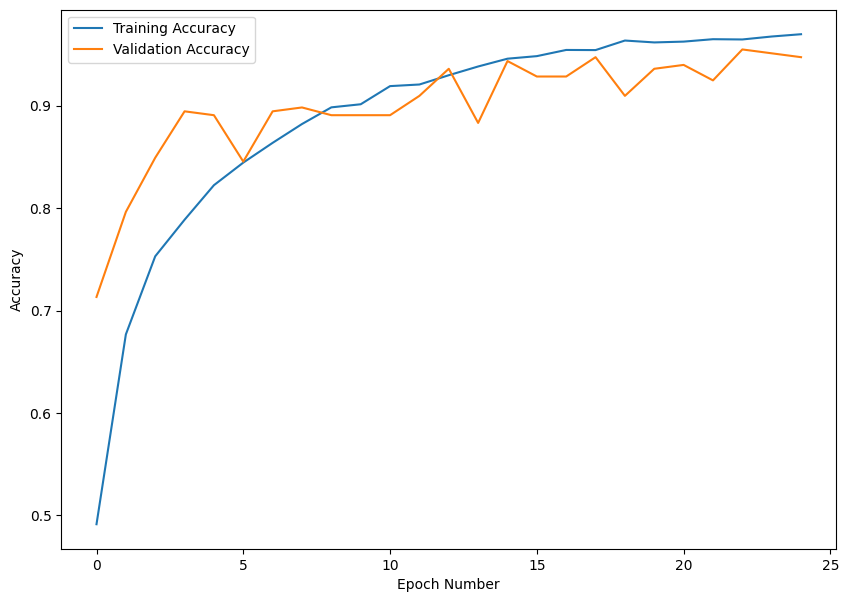

Test Batch number: 000, Test: Loss: 0.0091, Accuracy: 1.0000
Test Batch number: 001, Test: Loss: 0.0482, Accuracy: 0.9688
Test Batch number: 002, Test: Loss: 0.1280, Accuracy: 0.9688
Test Batch number: 003, Test: Loss: 0.6808, Accuracy: 0.7812
Test Batch number: 004, Test: Loss: 1.3480, Accuracy: 0.7188
Test Batch number: 005, Test: Loss: 0.1687, Accuracy: 0.9375
Test Batch number: 006, Test: Loss: 0.1270, Accuracy: 0.9688
Test Batch number: 007, Test: Loss: 0.0131, Accuracy: 1.0000
Test Batch number: 008, Test: Loss: 0.4856, Accuracy: 0.8889
Test accuracy: 0.9170


In [25]:
## Plot loss and Accuracy
plt.figure(figsize=(10, 7))
history = np.array(history)
plt.plot(history[:,0:2])
plt.legend(['Training Loss', 'Validation Loss'])
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.savefig('loss_curve.png')
plt.show()

plt.figure(figsize=(10, 7))
plt.plot(history[:,2:4])
plt.legend(['Training Accuracy', 'Validation Accuracy'])
plt.xlabel('Epoch Number')
plt.ylabel('Accuracy')
plt.savefig('accuracy_curve.png')
plt.show()


##------------------------Plot Batch Accuracy-----------------------------##
def computeTestSetAccuracy(model, loss_criterion):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    test_acc = 0.0
    test_loss = 0.0

    # Validation - No gradient tracking needed
    with torch.no_grad():
        model.eval()

        # Validation loop
        for j, (inputs, labels) in enumerate(test_data_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            loss = loss_criterion(outputs, labels)

            # Compute the total loss for the batch and add it to test_loss
            test_loss += loss.item() * inputs.size(0)

            _, predictions = torch.max(outputs.data, 1)
            correct_counts = predictions.eq(labels.data.view_as(predictions))
            acc = torch.mean(correct_counts.type(torch.FloatTensor))
            test_acc += acc.item() * inputs.size(0)
            print(f"Test Batch number: {j:03d}, Test: Loss: {loss.item():.4f}, Accuracy: {acc.item():.4f}")

    # Find average test loss and test accuracy
    avg_test_loss = test_loss / test_data_size
    avg_test_acc = test_acc / test_data_size

    print("Test accuracy: {:.4f}".format(avg_test_acc))


##-------------------------Load Model------------------------------------------##
# Load the best saved model during training.
model = torch.load("best_model.pt",weights_only=False)
# Evaluate the model's performance on the test dataset and print the results.
computeTestSetAccuracy(model, loss_func)

## Prediction Example


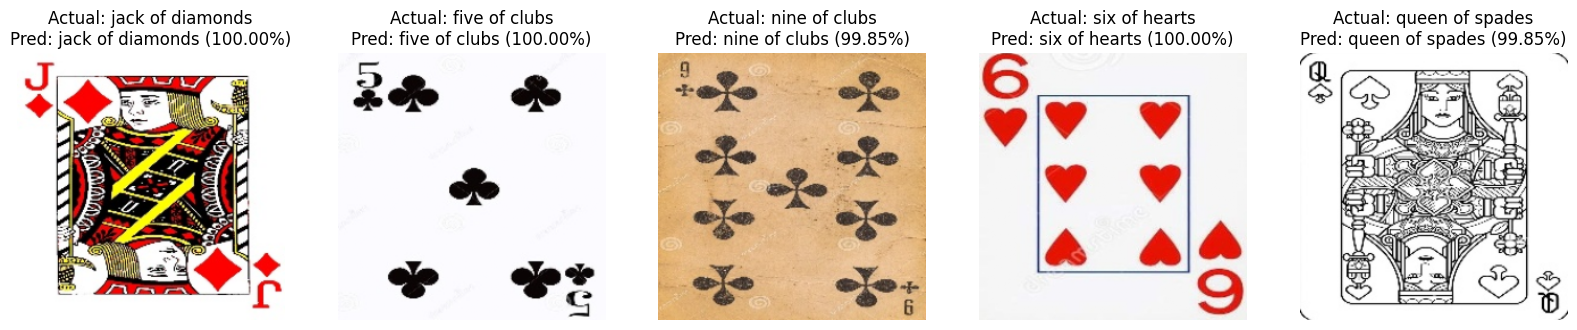

In [26]:
def unnormalize(image, mean, std):
    """Reverses the normalization to convert back to [0,1] range."""
    mean = torch.tensor(mean).view(3, 1, 1)
    std = torch.tensor(std).view(3, 1, 1)
    return image * std + mean  # Unnormalize

def predict_random_images(model, valid_data_loader, idx_to_class, device='cuda'):
    model.to(device)
    model.eval()

    data_iter = iter(valid_data_loader)
    images, labels = next(data_iter)
    indices = random.sample(range(len(images)), 5)

    fig, axes = plt.subplots(1, 5, figsize=(20, 5))

    mean = [0.776, 0.7291, 0.7016]
    std = [0.3079, 0.3377, 0.3443]

    for i, idx in enumerate(indices):
        image = images[idx].unsqueeze(0).to(device)
        label = labels[idx].item()

        with torch.no_grad():
            output = model(image)
            ps = torch.exp(output)
            top_prob, top_class = ps.topk(1, dim=1)

        predicted_label = idx_to_class[top_class.cpu().numpy()[0][0]]
        confidence = top_prob.cpu().numpy()[0][0] * 100
        actual_label = idx_to_class[label]

        # Unnormalize for display
        img_np = unnormalize(images[idx].cpu(), mean, std)
        img_np = img_np.permute(1, 2, 0).numpy()  # Convert from (C, H, W) to (H, W, C)
        img_np = np.clip(img_np, 0, 1)  # Clip values to [0,1] for imshow

        axes[i].imshow(img_np)
        axes[i].axis("off")
        axes[i].set_title(f"Actual: {actual_label}\nPred: {predicted_label} ({confidence:.2f}%)", fontsize=12)

    plt.show()
valid_data_loader = DataLoader(data['valid'], batch_size=batch_size, shuffle=True);
predict_random_images(model, valid_data_loader, idx_to_class, device=device)